In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
full_data = pd.read_csv("../../data/processed/historical/train/lcl_data.csv")
df_100K = full_data.sample(100000, random_state=0)
df_100K.to_csv("../../data/processed/historical/train/lcl_data_100K.csv", index=False)

# Load Data

In [3]:
import torch
import numpy as np
import random
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(RANDOM_STATE)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
from pathlib import Path
from opensynth.data_modules.lcl_data_module import LCLDataModule
import pytorch_lightning as pl

import matplotlib.pyplot as plt

data_path = Path("../../data/processed/historical/train/lcl_data_100K.csv")
stats_path = Path("../../data/processed/historical/train/mean_std.csv")
outlier_path = Path("../../data/processed/historical/train/outliers.csv")

dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=100000, n_samples=100000)
dm.setup()

In [5]:
import torch
from opensynth.models.faraday import FaradayVAE
vae_model = torch.load("vae_model.pt")
vae_model.eval()

FaradayVAE(
  (encoder): Encoder(
    (encoder_layers): Sequential(
      (0): Linear(in_features=50, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): GELU(approximate='none')
      (8): Linear(in_features=64, out_features=32, bias=True)
      (9): GELU(approximate='none')
      (10): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (latent): Linear(in_features=18, out_features=16, bias=True)
    (latent_activations): GELU(approximate='none')
    (decoder_layers): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): GELU(approximate='no

In [6]:
from opensynth.models.faraday.gaussian_mixture.prepare_gmm_input import encode_data_for_gmm

next_batch = next(iter(dm.train_dataloader()))
input_tensor = encode_data_for_gmm(data=next_batch, vae_module=vae_model)
input_data = input_tensor.detach().numpy()
n_samples = len(input_tensor)

In [7]:
N_COMPONENTS = 700
REG_COVAR = 1e-4
EPOCHS = 25
IDX = 0
CONVERGENCE_TOL = 1e-2


In [8]:
input_tensor.shape, input_tensor[0][0]

(torch.Size([100000, 18]), tensor(0.4973, grad_fn=<SelectBackward0>))

# Init GMM

In [9]:
from opensynth.models.faraday.new_gmm import gmm_utils

labels_, means_, responsibilities_ = gmm_utils.initialise_centroids(
        X=input_data, n_components=N_COMPONENTS
    )
print(labels_.dtype, responsibilities_.dtype, means_.dtype)

torch.float32 torch.float32 torch.float32


In [10]:
from opensynth.models.faraday.new_gmm.train_gmm import initialise_gmm_params

gmm_init_params = initialise_gmm_params(
    X=input_data,
    n_components = N_COMPONENTS,
    reg_covar=REG_COVAR,
)
print(gmm_init_params["precision_cholesky"][IDX][0][0])
print(gmm_init_params["weights"].sum())

tensor(8.2479)
tensor(1.)


# Torch GMM

In [67]:
from opensynth.models.faraday.new_gmm.train_gmm import initialise_gmm_params, training_loop
from opensynth.models.faraday.new_gmm.new_gmm_model import GaussianMixtureModel


gmm_init_params = initialise_gmm_params(
    X=input_data,
    n_components = N_COMPONENTS,
    reg_covar=REG_COVAR,
)

means = gmm_init_params["means"].detach().numpy()
weights = gmm_init_params["weights"].detach().numpy()
prec_chol = gmm_init_params["precision_cholesky"].detach().numpy()
print(f"Initial prec chol: {prec_chol[IDX][0][0]}. Initial mean: {means[IDX][0]}")

torch_gmm = GaussianMixtureModel(
    num_components=N_COMPONENTS,
    num_features = input_data.shape[1],
    reg_covar=REG_COVAR,
    print_idx=IDX
)
torch_gmm.initialise(gmm_init_params)
trained_model, log_prob_epochs = training_loop(model=torch_gmm, data=input_tensor, max_iter=EPOCHS)

Initial prec chol: 7.106993198394775. Initial mean: -0.38109374046325684


  4%|▍         | 1/25 [00:08<03:13,  8.07s/it]

log prob:  tensor(1.9129, grad_fn=<NegBackward0>)


  4%|▍         | 1/25 [00:12<04:52, 12.19s/it]


KeyboardInterrupt: 

# SK Learn GMM Manual

In [ ]:
import numpy as np
from scipy.special import logsumexp
from scipy import linalg

def is_symmetric_positive_definite(covariance):
    is_symmetric = np.all([np.allclose(covariance[i], covariance[i].T) for i in range(covariance.shape[0])])
    is_positive_definite = np.all([np.all(np.linalg.eigvalsh(covariance[i]) > 0.0) for i in range(covariance.shape[0])])
    return is_symmetric and is_positive_definite

def _estimate_gaussian_parameters(X, resp, reg_covar=REG_COVAR):
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[:: n_features + 1] += reg_covar

    check_covariances = is_symmetric_positive_definite(covariances)
    if not check_covariances:
        raise ValueError("Covariance matrix is not positive definite.")
    return nk, means, covariances

def _compute_precision_cholesky(covariances):
    estimate_precision_error_message = (
        "Fitting the mixture model failed because some components have "
        "ill-defined empirical covariance (for instance caused by singleton "
        "or collapsed samples). Try to decrease the number of components, "
        "or increase reg_covar."
    )

    n_components, n_features, _ = covariances.shape
    precisions_chol = np.empty((n_components, n_features, n_features))
    for k, covariance in enumerate(covariances):
        try:
            cov_chol = linalg.cholesky(covariance, lower=True)
        except linalg.LinAlgError:
            raise ValueError(estimate_precision_error_message)
        precisions_chol[k] = linalg.solve_triangular(
            cov_chol, np.eye(n_features), lower=True
        ).T
    return precisions_chol

def _compute_log_det_cholesky(matrix_chol, n_features):
    n_components, _, _ = matrix_chol.shape
    log_det_chol = np.sum(
        np.log(matrix_chol.reshape(n_components, -1)[:, :: n_features + 1]), 1
    )
    return log_det_chol

def _estimate_log_gaussian_prob(X, means, precisions_chol):
    n_samples, n_features = X.shape
    n_components, _ = means.shape

    log_det = _compute_log_det_cholesky(precisions_chol, n_features)

    log_prob = np.empty((n_samples, n_components))
    for k, (mu, prec_chol) in enumerate(zip(means, precisions_chol)):
        y = np.dot(X, prec_chol) - np.dot(mu, prec_chol)
        log_prob[:, k] = np.sum(np.square(y), axis=1)
    return -0.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det

def _estimate_log_weights(weights):
        return np.log(weights)

def _estimate_weighted_log_prob(X, means, precisions_chol, weights):
        return _estimate_log_gaussian_prob(X, means, precisions_chol) + _estimate_log_weights(weights)


def _estimate_log_prob_resp(X, means, precisions_chol, weights):
    weighted_log_prob = _estimate_weighted_log_prob(X, means, precisions_chol, weights)
    log_prob_norm = logsumexp(weighted_log_prob, axis=1)
    with np.errstate(under="ignore"):
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
    return log_prob_norm, log_resp

def _e_step(X,means, precisions_chol, weights):
    log_prob_norm, log_resp = _estimate_log_prob_resp(X, means, precisions_chol, weights)
    return np.mean(log_prob_norm), log_resp

def _m_step(X, log_reponsibilities, reg_covar=REG_COVAR):

    weights_, means_, covariances_ = _estimate_gaussian_parameters(X,np.exp(log_reponsibilities),reg_covar=reg_covar)
    weights_ /= weights_.sum()

    precision_cholesky_ = _compute_precision_cholesky(covariances=covariances_)

    return precision_cholesky_, weights_, means_, covariances_

In [ ]:
means = gmm_init_params["means"].detach().numpy()
weights = gmm_init_params["weights"].detach().numpy()
prec_chol = gmm_init_params["precision_cholesky"].detach().numpy()

print(f"Initial prec chol: {prec_chol[IDX][0][0]}. Initial mean: {means[IDX][0]}")

converged = False
lower_bound = -np.inf
np_log_prob_epochs = []
for i in range(EPOCHS):
    prev_lower_bound = lower_bound

    print(f"Old Prec Chol: {prec_chol[IDX][0][0]}. Old means: {means[IDX][0]}")
    log_prob, log_resp = _e_step(input_data, means, prec_chol, weights)
    prec_chol, weights, means, covar = _m_step(input_data, log_resp)

    print(f"New prec chol: {prec_chol[IDX][0][0]}. New means: {means[IDX][0]}")

    # Converegence
    lower_bound = -log_prob
    change = abs(lower_bound - prev_lower_bound)
    print(f"log prob: {log_prob}, change: {change}")
    np_log_prob_epochs.append(lower_bound)
    if change < CONVERGENCE_TOL:
        converged = True
        break

print(f'Converged: {converged}. Number of iterations: {i}')

Initial prec chol: 5.304963111877441. Initial mean: -0.03158539533615112
Old Prec Chol: 5.304963111877441. Old means: -0.03158539533615112
New prec chol: 5.354319690242408. New means: -0.0666737731178448
log prob: -2.034874961962169, change: inf
Old Prec Chol: 5.354319690242408. Old means: -0.0666737731178448
New prec chol: 5.425739612214089. New means: -0.07675008384865534
log prob: -1.5267240808098947, change: 0.5081508811522741
Old Prec Chol: 5.425739612214089. Old means: -0.07675008384865534
New prec chol: 5.431166511078023. New means: -0.07761530600745582
log prob: -1.2964411424379916, change: 0.23028293837190317
Old Prec Chol: 5.431166511078023. Old means: -0.07761530600745582
New prec chol: 5.447434660478251. New means: -0.0726697539764158
log prob: -1.1458856748389143, change: 0.15055546759907723
Old Prec Chol: 5.447434660478251. Old means: -0.0726697539764158
New prec chol: 5.481500604338222. New means: -0.06364515597704859
log prob: -1.0218226561414847, change: 0.124063018697

In [16]:
import matplotlib.pyplot as plt

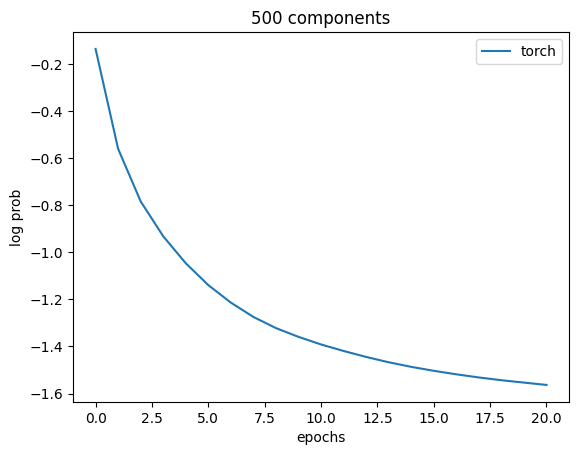

In [17]:
torch_log_prob_epochs = [log_prob.detach().item() for log_prob in log_prob_epochs]
plt.plot(np.arange(0, 21), torch_log_prob_epochs, label='torch')
# plt.plot(np.arange(0, i+1), np_log_prob_epochs, label='numpy', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('log prob')
plt.title('500 components')
plt.legend()
plt.show()

# SK Learn GMM Epoch

In [14]:
from sklearn.mixture import GaussianMixture

init_weights = gmm_init_params["weights"]
init_means = gmm_init_params["means"]

skgmm = GaussianMixture(n_components=N_COMPONENTS, covariance_type='full', tol=CONVERGENCE_TOL, max_iter=EPOCHS, random_state=0, means_init = init_means, weights_init=init_weights, verbose=2, verbose_interval=1)
skgmm.fit(input_data)
skgmm_pred = skgmm.predict(input_data)

Initialization 0
  Iteration 1	 time lapse 7.33542s	 ll change inf
  Iteration 2	 time lapse 3.47101s	 ll change 0.51692
  Iteration 3	 time lapse 3.50806s	 ll change 0.23751
  Iteration 4	 time lapse 3.10982s	 ll change 0.15756
  Iteration 5	 time lapse 2.86738s	 ll change 0.12937
  Iteration 6	 time lapse 3.63363s	 ll change 0.12114
  Iteration 7	 time lapse 3.53204s	 ll change 0.10132
  Iteration 8	 time lapse 2.65495s	 ll change 0.07272
  Iteration 9	 time lapse 2.38858s	 ll change 0.05265
  Iteration 10	 time lapse 2.66181s	 ll change 0.04181
  Iteration 11	 time lapse 2.27012s	 ll change 0.03483
  Iteration 12	 time lapse 2.43596s	 ll change 0.03022
  Iteration 13	 time lapse 2.35215s	 ll change 0.02537
  Iteration 14	 time lapse 2.29618s	 ll change 0.02154
  Iteration 15	 time lapse 2.25619s	 ll change 0.01948
  Iteration 16	 time lapse 2.35089s	 ll change 0.01818
  Iteration 17	 time lapse 2.31402s	 ll change 0.01645
  Iteration 18	 time lapse 2.36858s	 ll change 0.01466
  Iter

In [15]:
skgmm.converged_, skgmm.n_iter_

(True, 24)

# Torch Lightning

In [13]:
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningDataModule
class CustomDataset(Dataset):
    def __init__(self, data_tensor: torch.Tensor):
        self.data = data_tensor
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    
class CustomDataModule(LightningDataModule):
    def __init__(self, data_tensor: torch.Tensor, batch_size: int):
        super().__init__()
        self.data_tensor = data_tensor
        self.batch_size = batch_size
    def setup(self, stage=""):
        self.custom_ds = CustomDataset(self.data_tensor)
    def train_dataloader(self):
        return DataLoader(self.custom_ds, batch_size=self.batch_size, shuffle=False, generator=g, worker_init_fn=seed_worker)
    
custom_dm = CustomDataModule(data_tensor=input_tensor, batch_size=25000)
custom_dm.setup(stage="")

In [14]:

for i in range(5):
    print(next(iter(custom_dm.train_dataloader()))[0][0])

tensor(0.4973, grad_fn=<SelectBackward0>)
tensor(0.4973, grad_fn=<SelectBackward0>)
tensor(0.4973, grad_fn=<SelectBackward0>)
tensor(0.4973, grad_fn=<SelectBackward0>)
tensor(0.4973, grad_fn=<SelectBackward0>)


In [40]:
from opensynth.models.faraday.new_gmm.new_gmm_model import GaussianMixtureLightningModule, GaussianMixtureModel
gmm_module = GaussianMixtureModel(
    num_components=N_COMPONENTS,
    num_features = input_data.shape[1],
    reg_covar=REG_COVAR,
    print_idx=IDX
)
gmm_module.initialise(gmm_init_params)
print(f"Initial prec chol: {gmm_module.precision_cholesky[IDX][0][0]}. Initial mean: {gmm_module.means[IDX][0]}")

gmm_lightning_module = GaussianMixtureLightningModule(
    gmm_module = gmm_module,
    vae_module = vae_model,
    num_components = gmm_module.num_components,
    num_features = gmm_module.num_features,
    reg_covar = gmm_module.reg_covar,
    convergence_tolerance = CONVERGENCE_TOL,
    compute_on_batch=False
)
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator="cpu", deterministic=True )
trainer.fit(gmm_lightning_module, custom_dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                      | Type                    | Params | Mode 
------------------------------------------------------------------------------
0 | gmm_module                | GaussianMixtureModel    | 0      | train
1 | vae_module                | FaradayVAE              | 402 K  | eval 
2 | weight_metric             | WeightsMetric           | 0      | train
3 | mean_metric               | MeansMetric             | 0      | train
4 | precision_ch

Initial prec chol: 8.24792194366455. Initial mean: -0.4213249683380127
Epoch 0: 100%|██████████| 4/4 [00:06<00:00,  0.58it/s, v_num=88]Local weights at rank: 0 - means: 0.0056, -0.4014
Reduced weights, means, covar: 0.0056, -0.4014, 0.0061
log prob:  tensor(3.0380)
Epoch 1: 100%|██████████| 4/4 [00:06<00:00,  0.62it/s, v_num=88]Local weights at rank: 0 - means: 0.0045, -0.3822
Reduced weights, means, covar: 0.0045, -0.3822, 0.0047
log prob:  tensor(2.4274)
Epoch 2: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=88]Local weights at rank: 0 - means: 0.0060, -0.3719
Reduced weights, means, covar: 0.0060, -0.3719, 0.0035
log prob:  tensor(2.2690)
Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  0.71it/s, v_num=88]Local weights at rank: 0 - means: 0.0066, -0.3770
Reduced weights, means, covar: 0.0066, -0.3770, 0.0033
log prob:  tensor(2.2098)
Epoch 4: 100%|██████████| 4/4 [00:05<00:00,  0.74it/s, v_num=88]Local weights at rank: 0 - means: 0.0074, -0.3834
Reduced weights, means, covar: 0.00

## Run sk-learn GMM batch learning

In [42]:
from sklearn.mixture import GaussianMixture
init_weights = gmm_init_params["weights"]
init_means = gmm_init_params["means"]

skgmm = GaussianMixture(n_components=N_COMPONENTS, covariance_type='full', tol=CONVERGENCE_TOL, max_iter=EPOCHS, random_state=0, means_init = init_means, weights_init=init_weights, warm_start=True)

dl = custom_dm.train_dataloader()
next_batch = next(iter(dl))
for batch_num, batch_data in enumerate(dl):
    print("Batch number: ", batch_num)
    input_data = batch_data.detach().numpy()
    n_samples = len(input_tensor)
    skgmm.fit(input_data)
    print("means: ", skgmm.means_)


Batch number:  0
means:  [[-0.29049615 -1.8366832   0.57180723 ... -1.77699099  8.23024724
   3.71545809]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.6029433  -1.25886529  0.50056563 ... -0.92390276  4.5986303
   3.4323372 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Batch number:  1
means:  [[-0.28136729 -1.87688303  0.55990058 ... -1.72341048  7.01239623
   3.07135017]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.6195133  -1.07679951  0.46372143 ... -0.87361805  6.48789928
   2.87193667]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Batch number:  2
means:  [[-0.2

In [43]:
gmm_lightning_module.gmm_module.means

tensor([[-0.4000, -2.1992,  0.9284,  ..., -2.3797,  6.8579,  4.3441],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4042, -2.2261,  0.5635,  ..., -1.8238,  2.7293,  3.6901],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [44]:
skgmm.means_

array([[-0.28269624, -1.77667548,  0.49735797, ..., -1.61740005,
         7.39031996,  3.07082778],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5851443 , -1.13857955,  0.55146234, ..., -0.98918665,
         6.43659724,  2.62936034],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [49]:
sklearn_sum_components = skgmm.means_.sum(axis=1)
ligthning_sum_components = gmm_lightning_module.gmm_module.means.sum(axis=1)
len(sklearn_sum_components[sklearn_sum_components==0]), len(ligthning_sum_components[ligthning_sum_components==0])

(613, 557)

In [37]:
gmm_lightning_module.gmm_module.weights[0], gmm_lightning_module.gmm_module.means[0][0]

(tensor(0.0303), tensor(-0.0037))

In [38]:
gmm_lightning_module.gmm_module.weights[0], gmm_lightning_module.gmm_module.means[0][0]

(tensor(0.0303), tensor(-0.0037))

In [39]:
gmm_lightning_module.weight_metric.compute()[0], gmm_lightning_module.mean_metric.compute()[0][0]

(tensor(0.0303), tensor(-0.0037))

# Compare

In [22]:
IDX = 0

In [23]:
df_compare_means = pd.DataFrame()
df_compare_means["skgmm"] = skgmm.means_[IDX]
df_compare_means["numpy"] = means[IDX]
df_compare_means["torch"] = trained_model.means[IDX]
df_compare_means["lightning"] = gmm_lightning_module.gmm_module.means[IDX]
df_compare_means

,skgmm,numpy,torch,lightning
0,-0.049669,-0.002572,-0.003688,-0.003688
1,-2.707486,-2.928096,-2.921445,-2.921445
2,0.303743,0.182399,0.184473,0.184473
3,-0.109831,0.073859,0.069771,0.069771
4,0.012985,0.100071,0.096574,0.096574
5,0.090285,0.095880,0.095612,0.095612
6,0.532626,0.414696,0.416915,0.416915
7,1.637247,1.820193,1.817437,1.817437
8,-0.010636,-0.035010,-0.034580,-0.034580
9,-1.646689,-1.858131,-1.849922,-1.849922


In [24]:
gmm_init_params["means"][IDX]

tensor([-0.0316, -2.8152,  0.0335,  0.3134,  0.1846,  0.0512,  0.2501,  2.1094,
        -0.0596, -2.1234,  0.4170, -0.0876, -0.0460,  0.7939,  1.4049, -2.3318,
         4.5358,  1.2399])

In [25]:
df_compare_covar = pd.DataFrame()
df_compare_covar["skgmm"] = skgmm.covariances_[IDX][0]
df_compare_covar["numpy"] = covar[IDX][0]
df_compare_covar["torch"] = trained_model.covariances.detach().numpy()[IDX][0]
df_compare_covar["lightning"] = gmm_lightning_module.gmm_module.covariances.detach().numpy()[IDX][0]
df_compare_covar

,skgmm,numpy,torch,lightning
0,0.017656,0.023301,0.023192,0.023192
1,-0.066879,-0.087802,-0.087399,-0.087399
2,-0.020881,-0.023410,-0.023240,-0.023240
3,0.029825,0.038741,0.038555,0.038555
4,0.021761,0.038529,0.038498,0.038498
5,0.007635,0.011312,0.011275,0.011275
6,-0.016465,-0.015620,-0.015511,-0.015511
7,0.016911,0.018662,0.018408,0.018408
8,-0.003483,-0.003759,-0.003729,-0.003729
9,-0.036252,-0.053979,-0.053962,-0.053962


In [26]:
df_compare_pre_chol = pd.DataFrame()
df_compare_pre_chol["skgmm"] = skgmm.precisions_cholesky_[IDX][0]
df_compare_pre_chol["numpy"] = prec_chol[IDX][0]
df_compare_pre_chol["torch"] = trained_model.precision_cholesky.detach().numpy()[IDX][0]
df_compare_pre_chol["lightning"] = gmm_lightning_module.gmm_module.precision_cholesky.detach().numpy()[IDX][0]
df_compare_pre_chol

,skgmm,numpy,torch,lightning
0,7.525883,6.551072,6.566400,6.566400
1,6.392054,5.355093,5.367649,5.367649
2,8.217989,6.399017,6.407043,6.407043
3,-4.754001,-3.943360,-3.980647,-3.980647
4,-7.994878,-6.608500,-6.620760,-6.620760
5,-11.216321,-8.930598,-8.937640,-8.937640
6,4.903968,5.665672,5.663373,5.663373
7,23.009691,13.939803,13.997698,13.997698
8,-1.872313,-1.436411,-1.420174,-1.420174
9,-17.834390,-14.562229,-14.590742,-14.590742


In [27]:
df_compare_weights = pd.DataFrame()
df_compare_weights["skgmm"] = skgmm.weights_[:10]
df_compare_weights["numpy"] = weights[:10]
df_compare_weights["torch"] = trained_model.weights[:10]
df_compare_weights["lightning"] = gmm_lightning_module.gmm_module.weights.detach().numpy()[:10]
df_compare_weights

,skgmm,numpy,torch,lightning
0,0.028506,0.030255,0.030305,0.030305
1,0.000200,0.000200,0.000200,0.000200
2,0.004717,0.004476,0.004478,0.004478
3,0.003403,0.003295,0.003295,0.003295
4,0.000600,0.000600,0.000600,0.000600
5,0.013637,0.011810,0.011803,0.011803
6,0.000320,0.000320,0.000320,0.000320
7,0.002364,0.002256,0.002256,0.002256
8,0.002725,0.002665,0.002665,0.002665
9,0.000240,0.000240,0.000240,0.000240


# Sampling

In [28]:
def sample(means_, covariances_, weights_, n_samples):
    rng = np.random.RandomState(RANDOM_STATE)
    n_samples_comp = rng.multinomial(n_samples, weights_)
    
    X = np.vstack(
            [
                rng.multivariate_normal(mean, covariance, int(sample))
                for (mean, covariance, sample) in zip(
                    means_, covariances_, n_samples_comp
                )
            ]
        )
    
    y = np.concatenate(
        [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
    )
    return (X, y)

In [29]:
def torch_sample(means_, covariances_, weights_, n_samples):
    # Set up the random generator with a specified seed
    generator = torch.Generator().manual_seed(RANDOM_STATE)
    
    # Sample component counts from the multinomial distribution
    n_samples_comp = torch.multinomial(weights_, n_samples, replacement=True, generator=generator).bincount(minlength=len(weights_))
    
    # Initialize lists to collect samples and labels
    X = []
    y = []
    
    # Sample from each component based on the number of samples
    for j, (mean, covariance, sample_count) in enumerate(zip(means_, covariances_, n_samples_comp)):
        if sample_count > 0:  # Only sample if we need samples from this component
            dist = torch.distributions.MultivariateNormal(
                mean, covariance
            )
            samples = dist.sample((sample_count,))
            X.append(samples)
            y.append(torch.full((sample_count,), j, dtype=torch.int64))
    
    # Concatenate all samples and labels into single tensors
    X = torch.vstack(X)
    y = torch.cat(y)
    
    return X, y

In [30]:
N_SAMPLES = 250

In [31]:
skgmm_samples = sample(skgmm.means_, skgmm.covariances_, skgmm.weights_, n_samples = N_SAMPLES)

skgmm_X, skgmm_y = skgmm_samples
skgmm_X[IDX], skgmm_y[IDX]

(array([-0.03887747, -2.9453815 ,  0.43721818, -0.20162165,  0.28700438,
         0.1723324 ,  0.81485445,  1.7054237 ,  0.08203473, -1.72305909,
         1.00713371,  0.04058859,  0.19500022,  1.00962552,  1.61513841,
        -2.42326199, 13.6384044 ,  3.04574583]),
 0)

In [32]:
samples = sample(means, covar, weights, n_samples = N_SAMPLES)

X, y = samples
X[IDX], y[IDX]

(array([-3.32496524e-02, -2.98268887e+00,  4.24690527e-01, -1.67278872e-01,
         2.24809896e-01,  1.06553346e-01,  6.26317064e-01,  1.26015957e+00,
         2.01741825e-03, -2.07779531e+00,  7.85901517e-01,  2.26804101e-01,
         8.27804447e-01,  5.43464053e-01,  1.54425686e+00, -2.70189306e+00,
         1.33966804e+01,  3.17510242e+00]),
 0)

In [33]:
train_model_samples = torch_sample(trained_model.means, trained_model.covariances, trained_model.weights, n_samples = N_SAMPLES)
train_model_X, train_model_y = train_model_samples
train_model_X[IDX], train_model_y[IDX]

(tensor([ 0.0756, -3.2072,  0.2560,  0.1855,  1.0395,  0.4390,  0.9301,  2.0937,
         -0.0612, -2.1749,  1.0848, -0.6334, -0.5247,  1.3095,  2.3578, -2.5904,
          5.2245,  2.1991]),
 tensor(0))

In [34]:
gmm_lightning_samples = torch_sample(gmm_lightning_module.gmm_module.means, gmm_lightning_module.gmm_module.covariances, gmm_lightning_module.gmm_module.weights, n_samples = N_SAMPLES)
gmm_lightning_X, gmm_lightning_y = train_model_samples
gmm_lightning_X[IDX], gmm_lightning_y[IDX]

(tensor([ 0.0756, -3.2072,  0.2560,  0.1855,  1.0395,  0.4390,  0.9301,  2.0937,
         -0.0612, -2.1749,  1.0848, -0.6334, -0.5247,  1.3095,  2.3578, -2.5904,
          5.2245,  2.1991]),
 tensor(0))